Installing required modules using pip

In [ ]:
pip install layoutparser torchvision

In [ ]:
pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-install-0ylu46t9/detectron2_4d7ebc5577b24ffabffa1cef3db93436
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-0ylu46t9/detectron2_4d7ebc5577b24ffabffa1cef3db93436
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
     |████████████████████████████████| 50 kB 2.7 MB/s 
     |████████████████████████████████| 78 kB 4.0 MB/s 
     |████████████████████████████████| 151 kB 40.3 MB/s 
     |████████████████████████████████| 130 kB 57.5 MB/s 
     |████████████████████████████████| 843 kB 36.5 MB/s 
     |████████████████████████████████| 749 kB 41.0 MB/s 
     |████████████████████████████████| 117 kB 44.4 MB/s 
  Created wheel for detectron2: filename=detectron2-0.5-cp37-cp37m-linux_x86_64.whl size=4907571 sha256=b2a0df533d684df82402851a558aa8db2d267382ea06997c4ed7f38927511d86
  Stored in directory: /tmp/pip-ephem-wheel-cache

In [ ]:
pip install pdf2img

In [ ]:
pip install "layoutparser[ocr]"


     |████████████████████████████████| 435 kB 3.9 MB/s 


In [ ]:
!sudo apt-get install poppler-utils 


Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
!sudo apt-get install tesseract-ocr-eng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (13.5 MB/s)
debconf: unable to initialize

In [ ]:
# importing required modules
import pdf2image
import numpy as np
import layoutparser as lp
import torchvision.ops.boxes as bops
import torch

In [ ]:
# connecting to the google drive to get the file for input
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading the test file
pdf_files= '/content/drive/MyDrive/publaynet/test.pdf'
img = np.asarray(pdf2image.convert_from_path(pdf_files)[0])

In [ ]:
#importing the modela dn fine tuning it with our values

model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

config.yaml?dl=1: 8.19kB [00:00, 8.29kB/s]
model_final.pth?dl=1: 856MB [00:14, 59.4MB/s]                           
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [ ]:
layout_result = model.detect(img)



/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


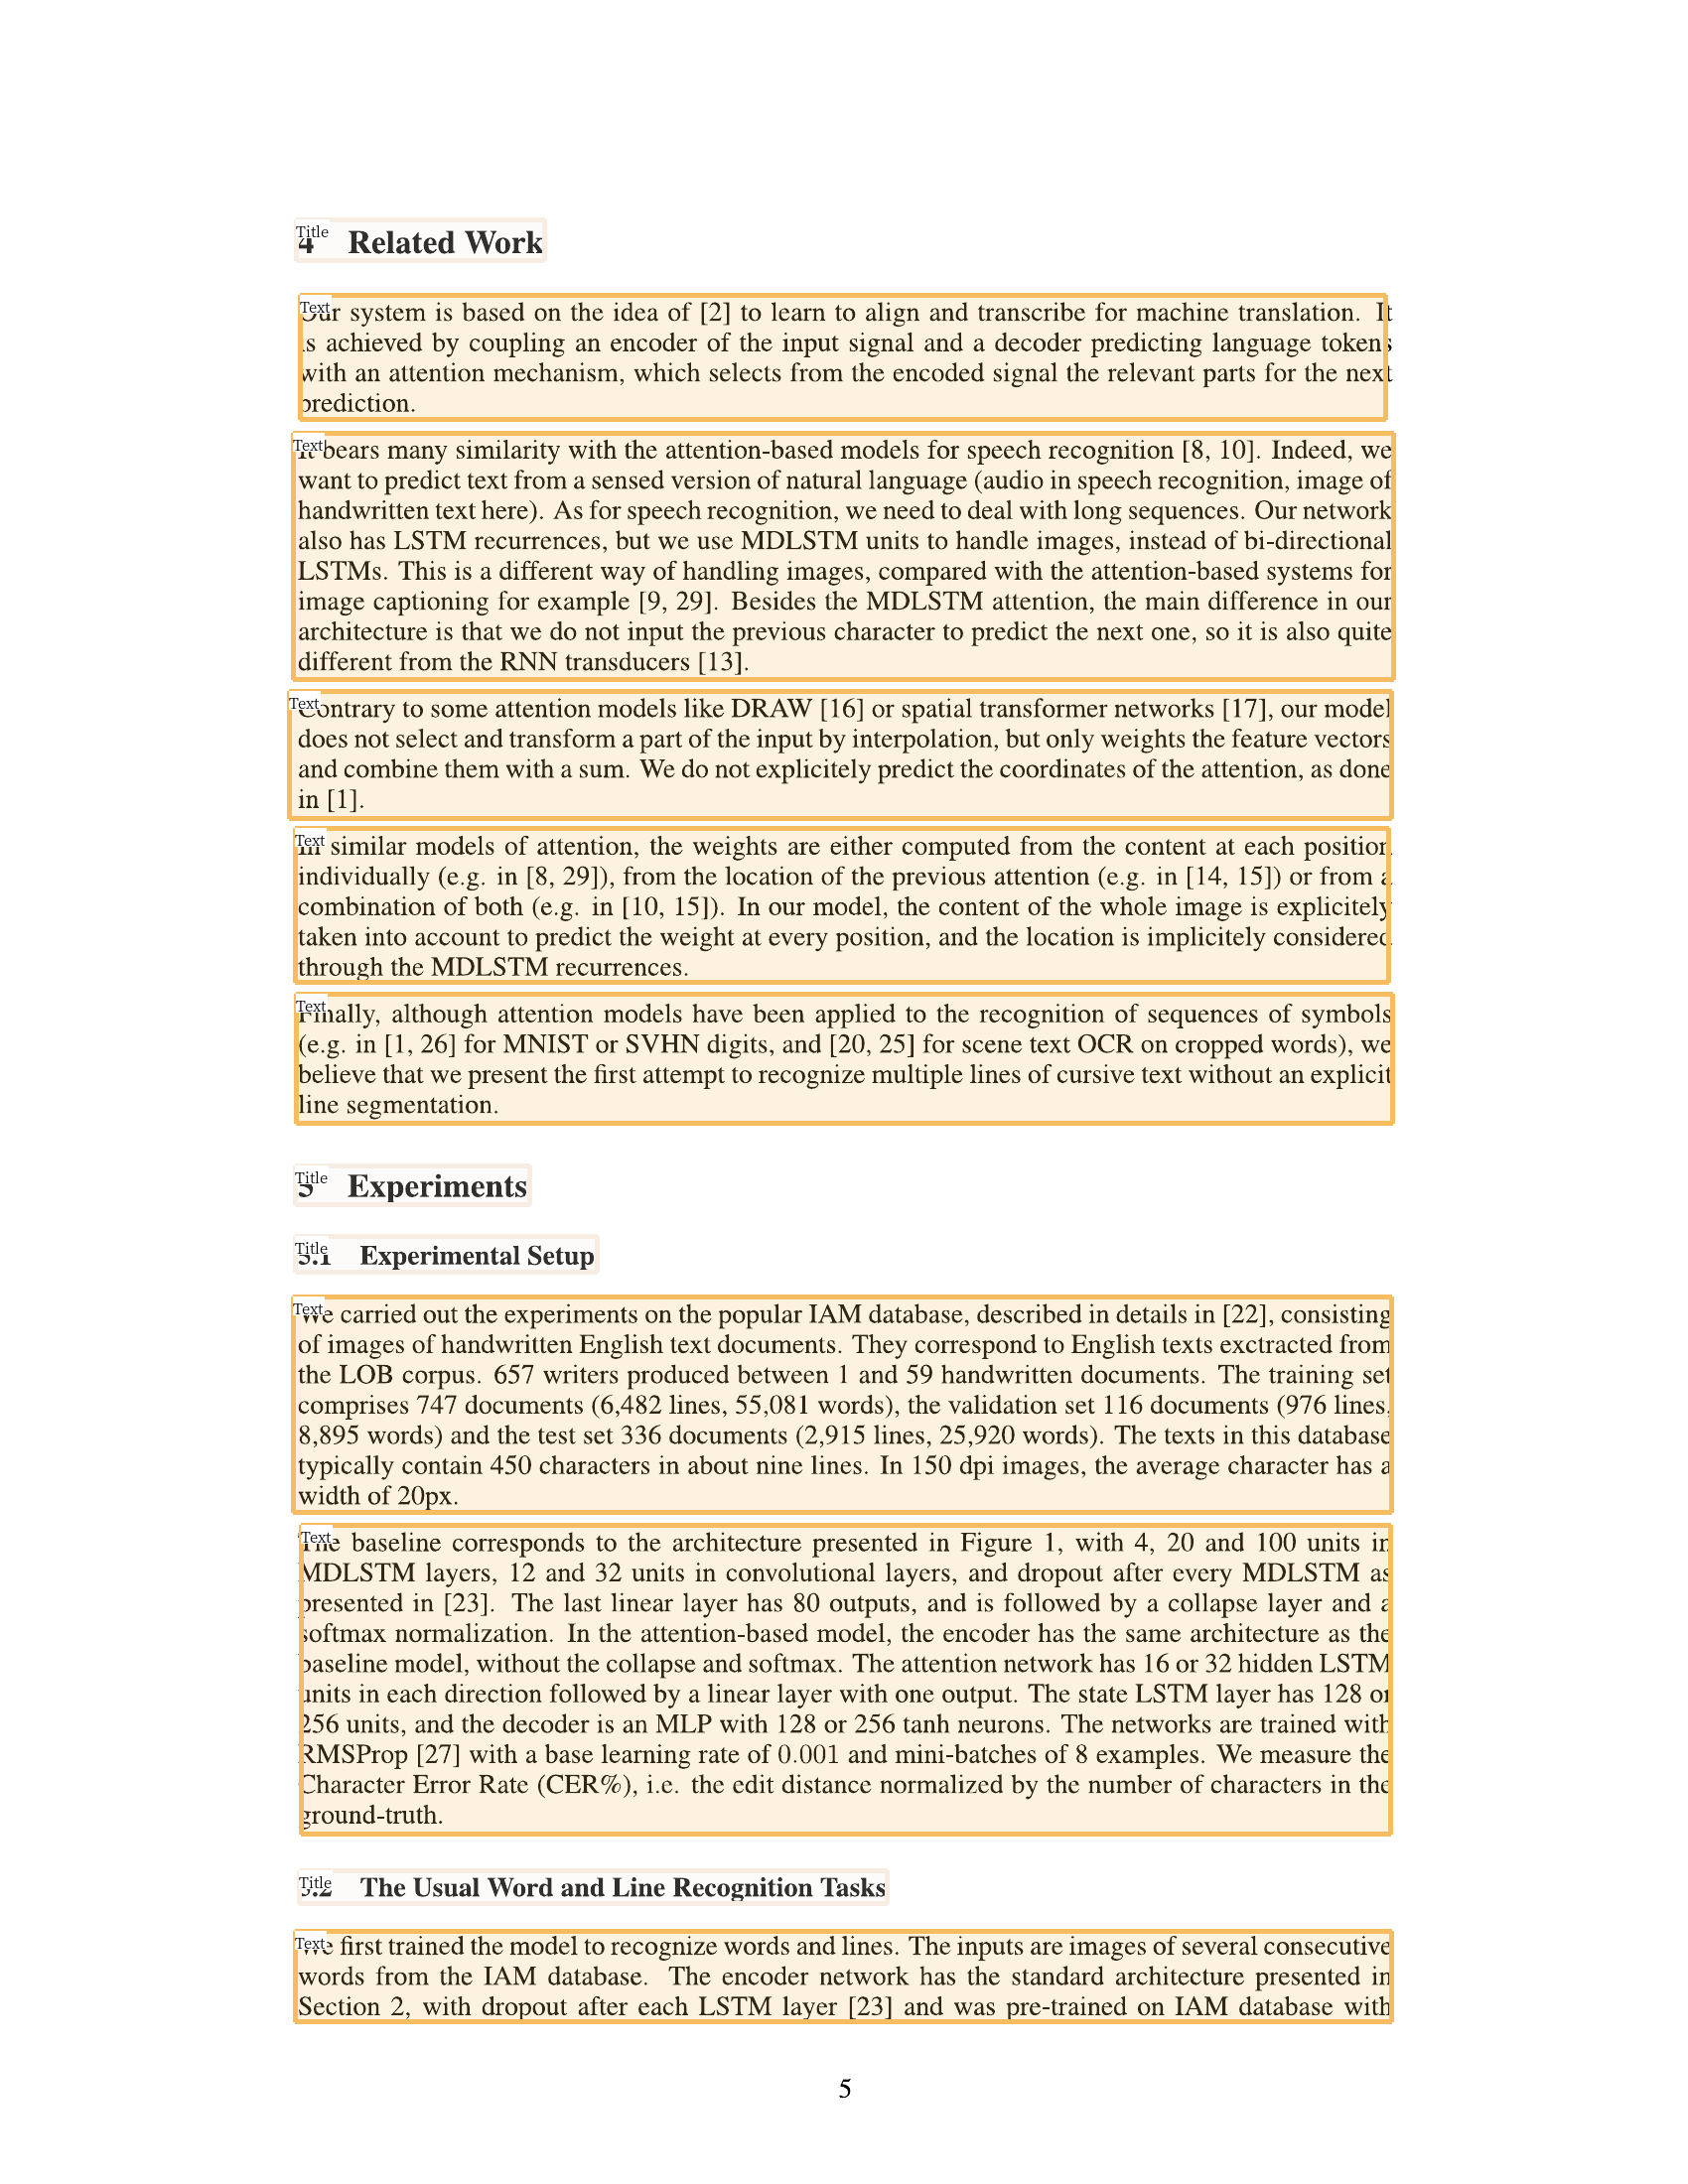

In [ ]:
# drawing the boxes around the document structures
lp.draw_box(img, layout_result,  box_width=5, box_alpha=0.2, show_element_type=True)

In [ ]:
#detecting text blocks
text_blocks = lp.Layout([b for b in layout_result if b.type=='Text'])

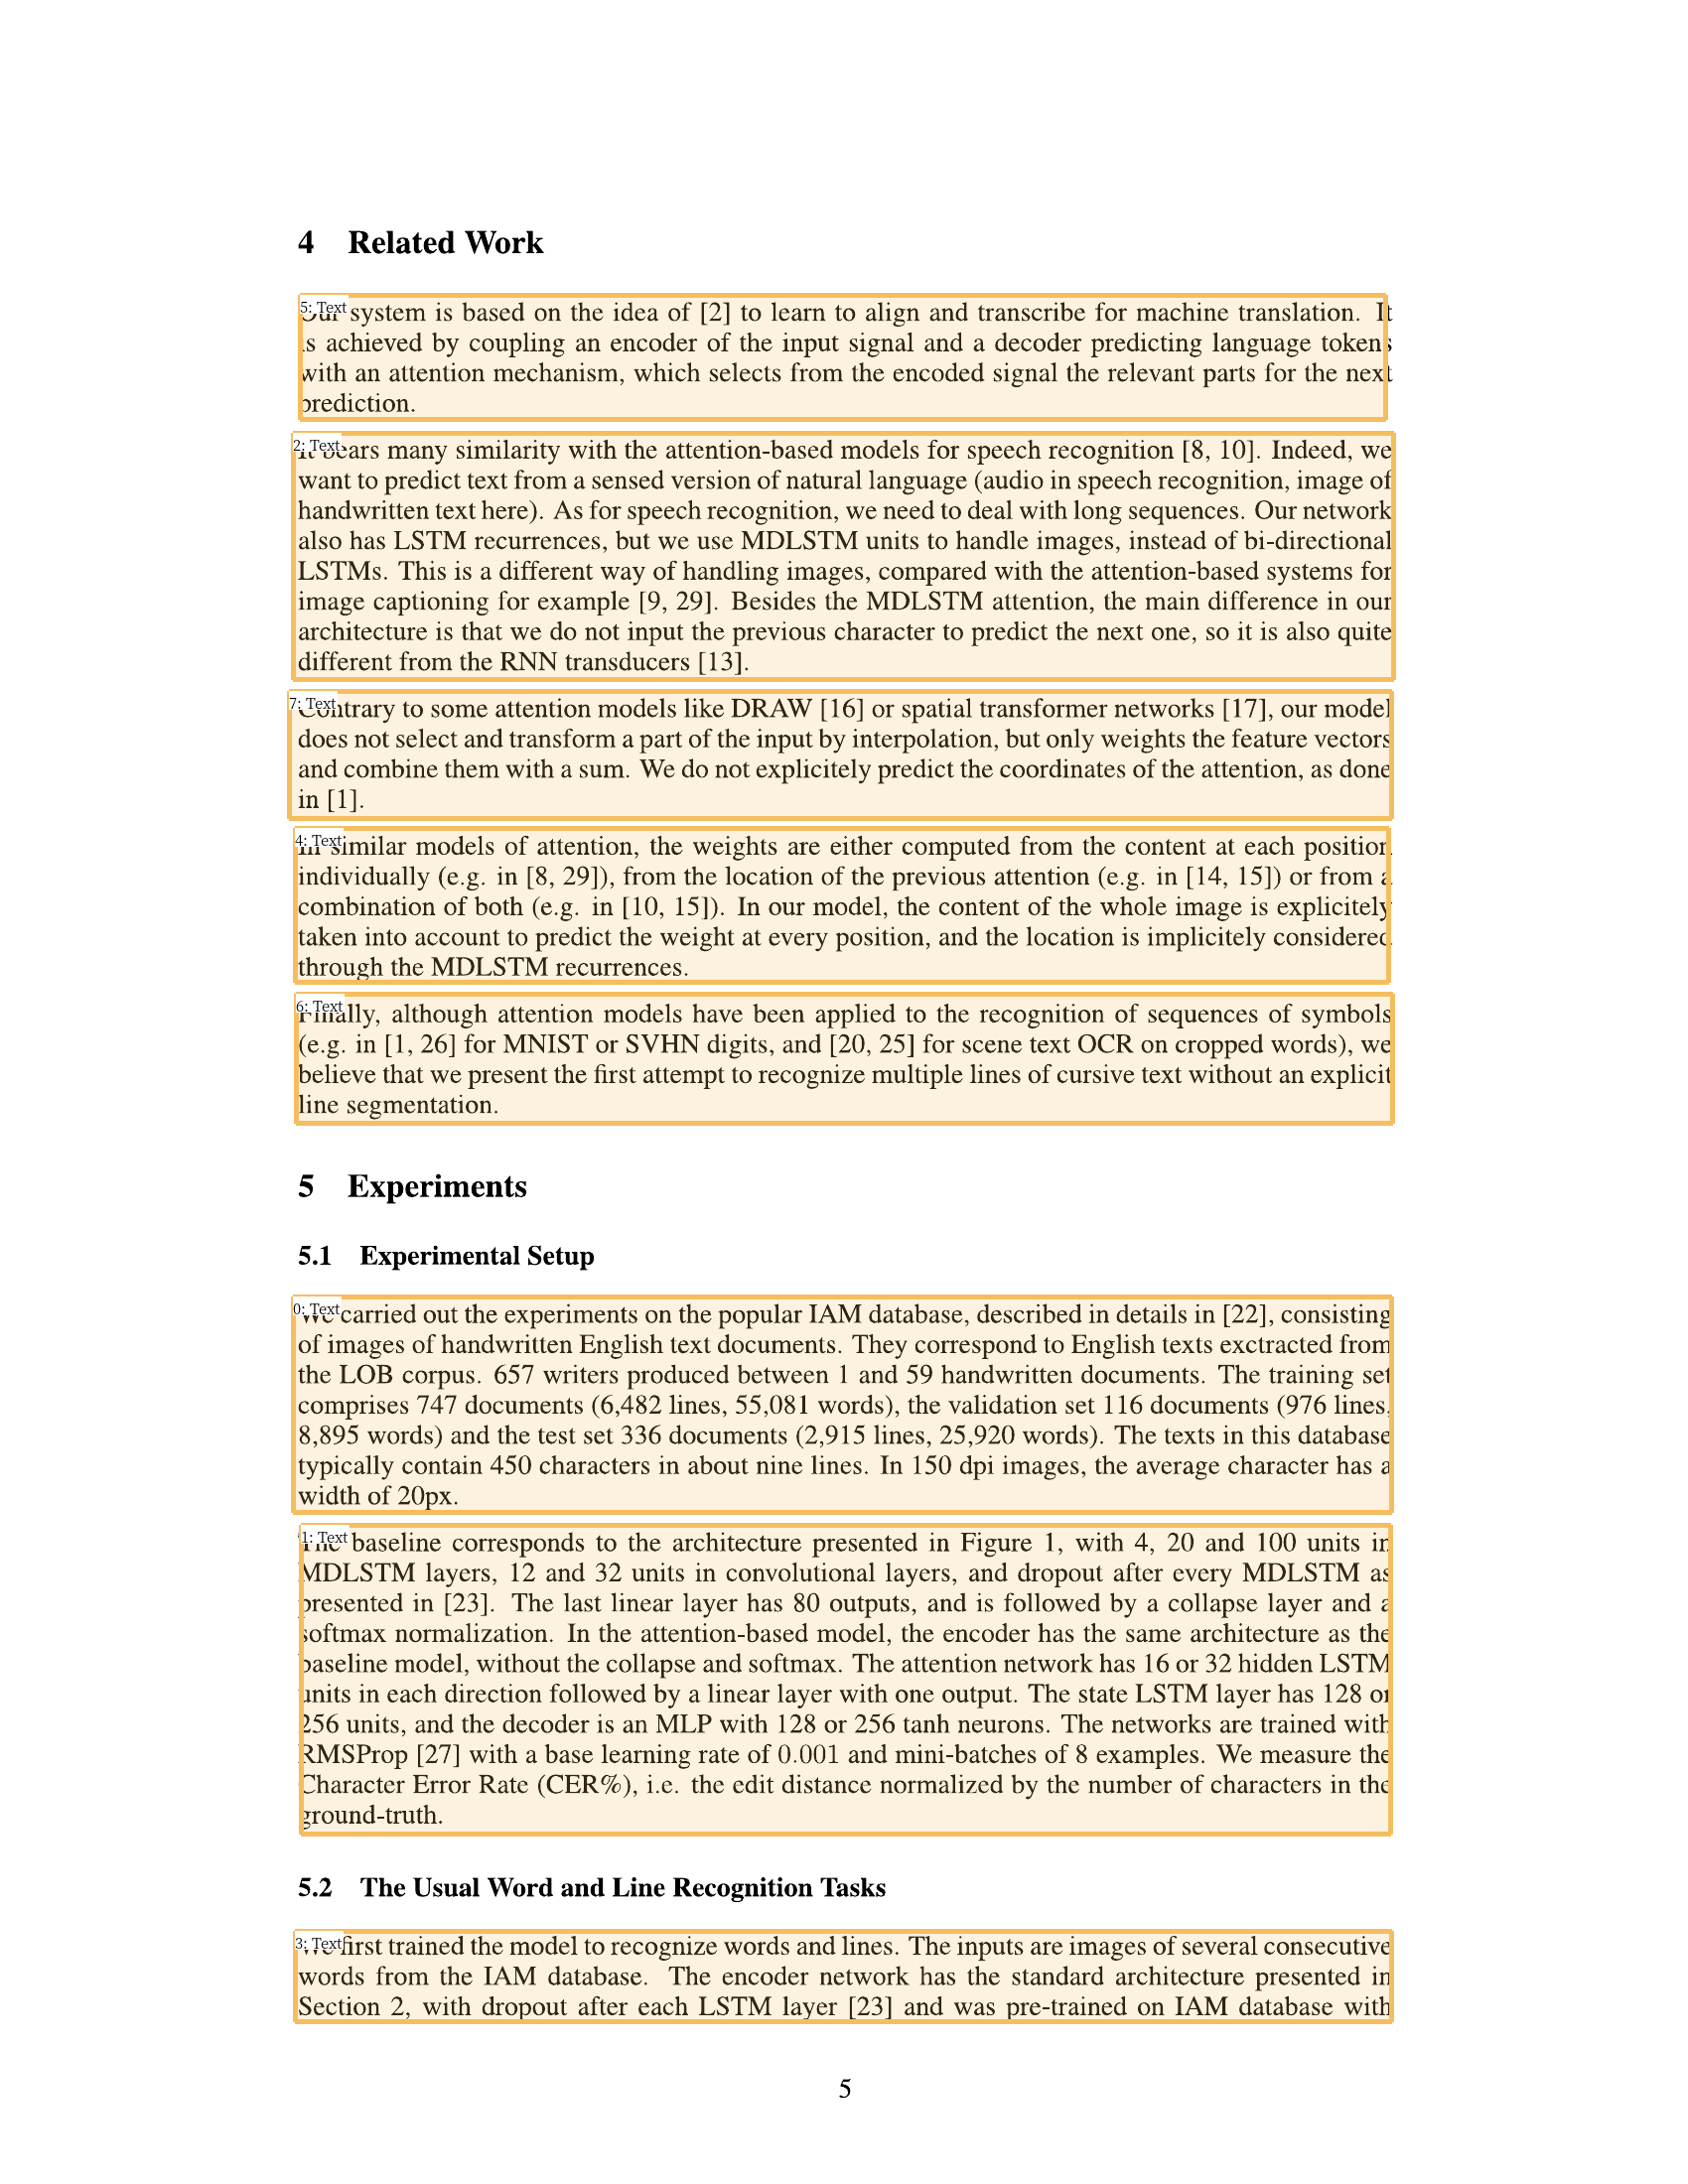

In [ ]:
#drawing bounding boxes around text blocks
lp.draw_box(img, text_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

Using OCR to get text in the text blocks

In [ ]:
ocr_agent = lp.TesseractAgent(languages='eng')

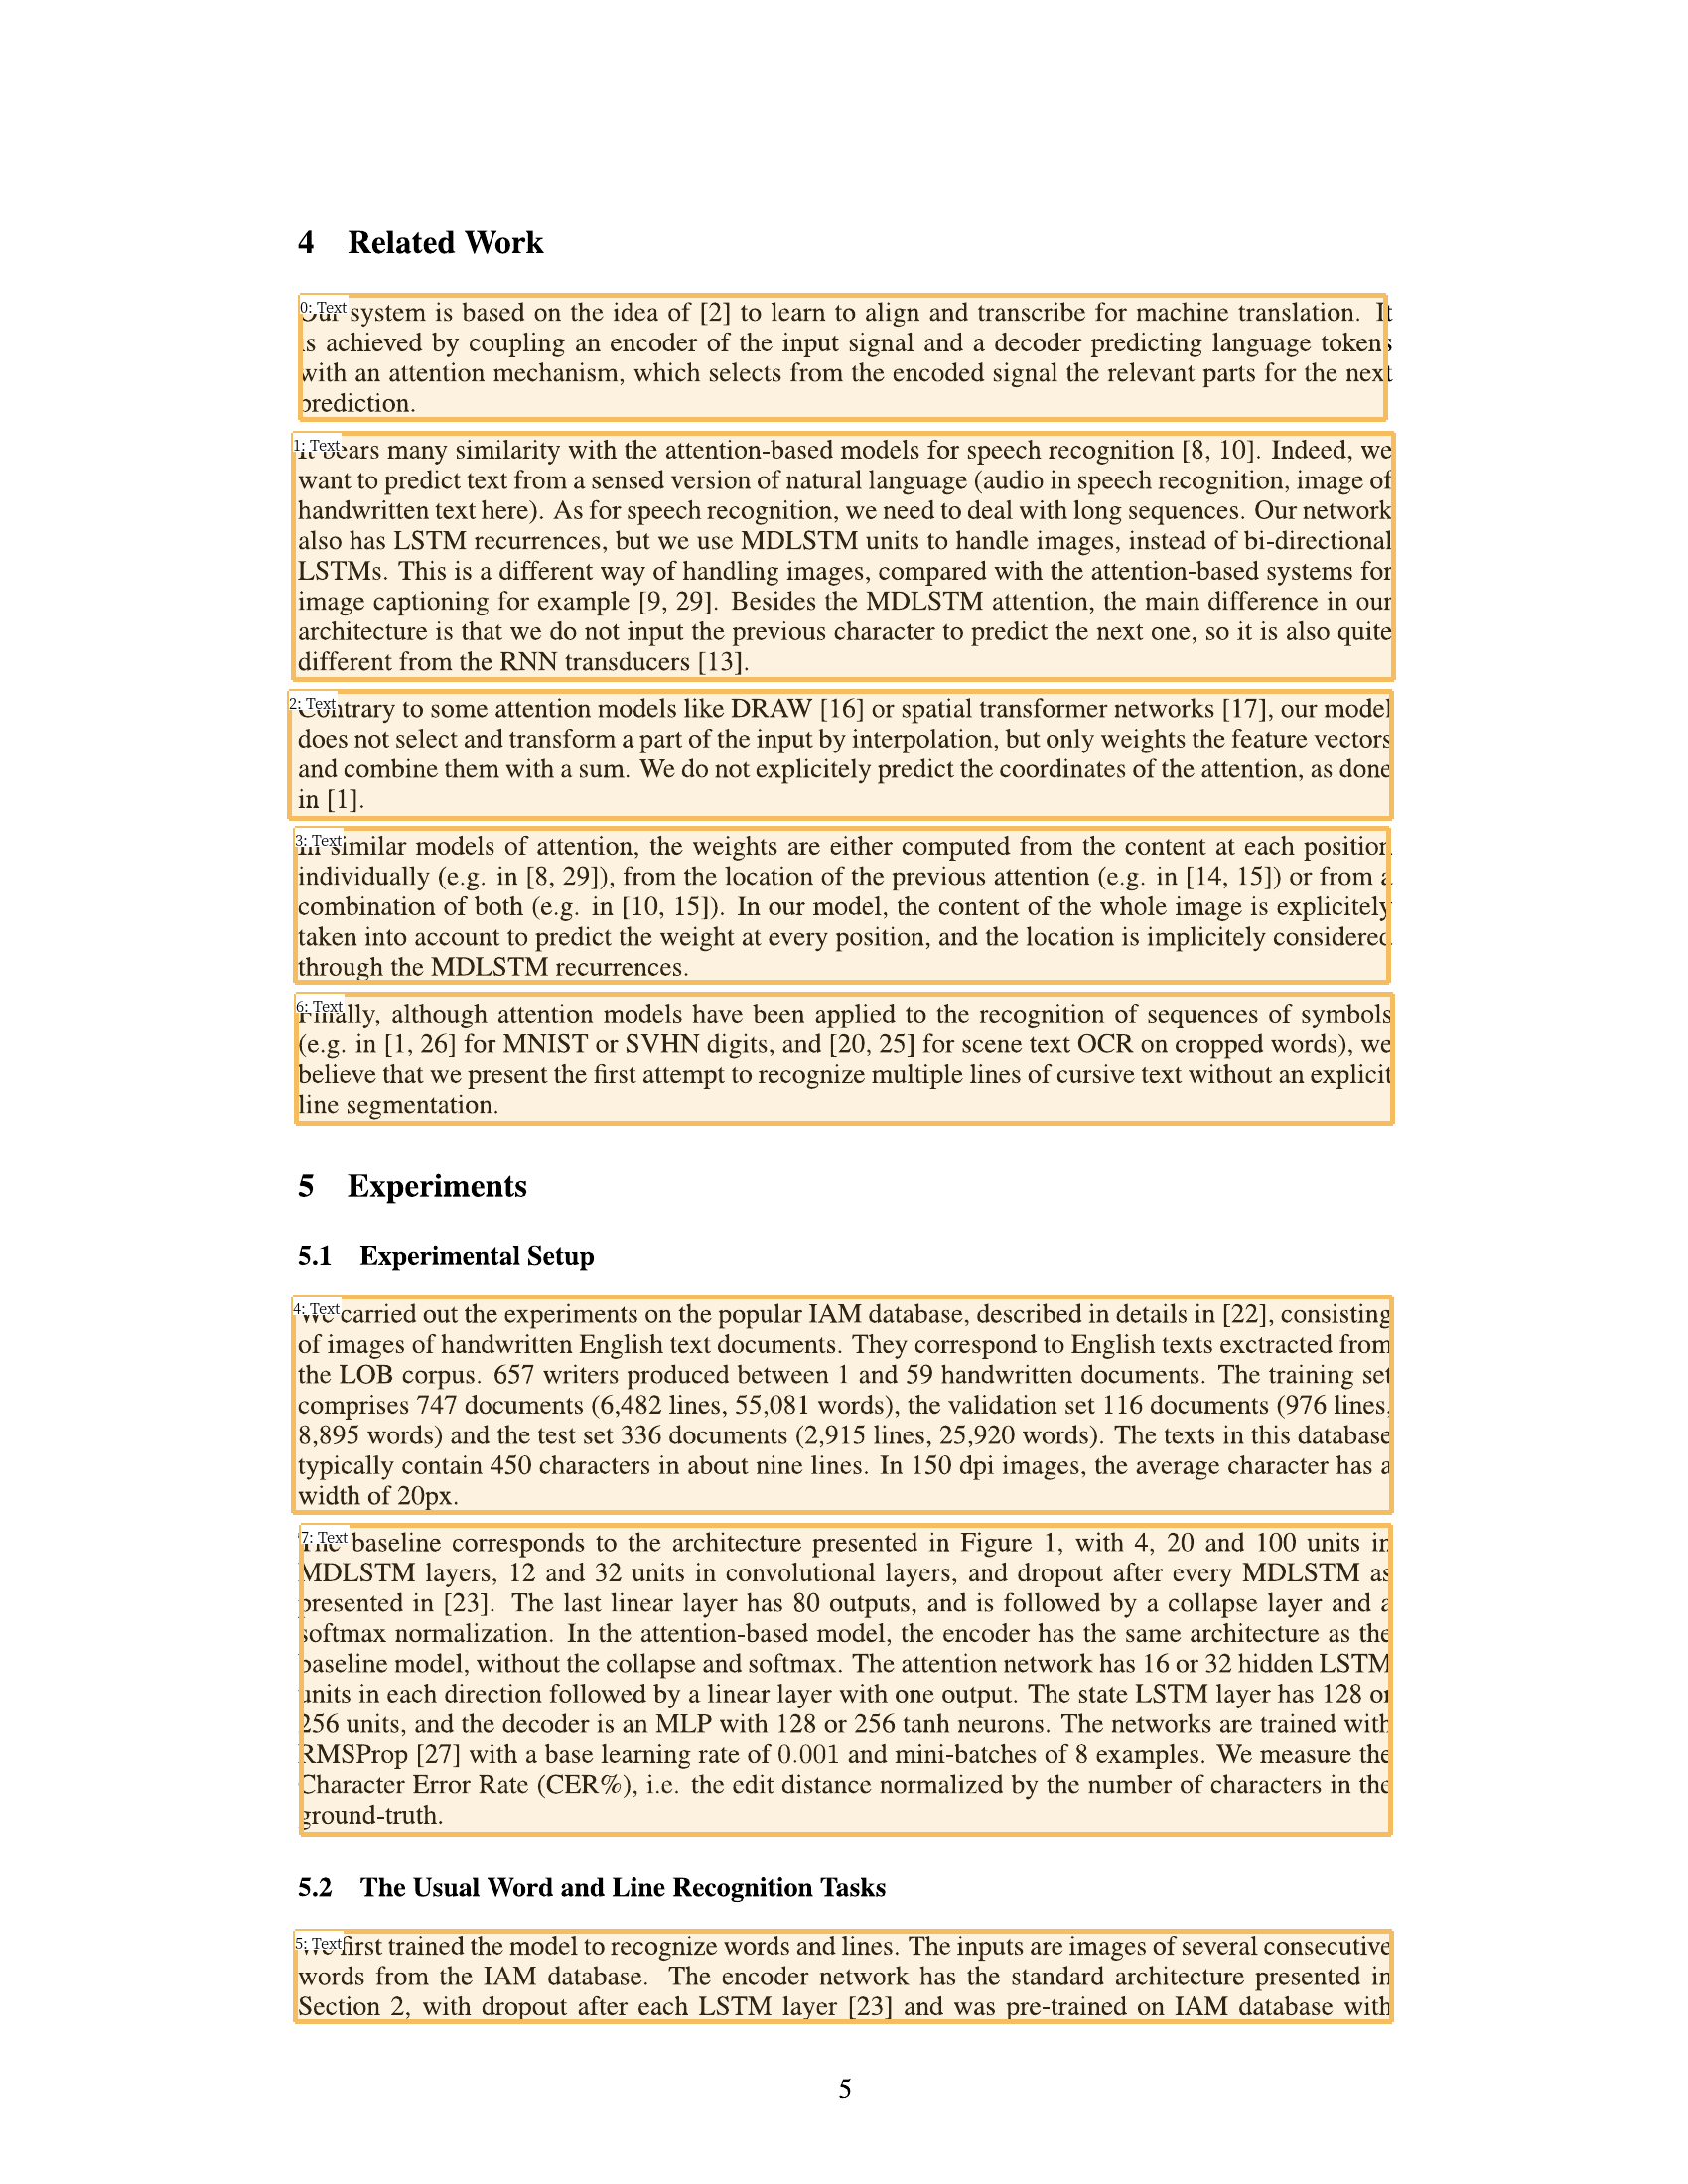

In [ ]:
image_width = len(img[0])

# Sort element ID of the left column based on y1 coordinate
left_interval = lp.Interval(0, image_width/2, axis='x').put_on_canvas(img)
left_blocks = text_blocks.filter_by(left_interval, center=True)._blocks
left_blocks.sort(key = lambda b:b.coordinates[1])

# Sort element ID of the right column based on y1 coordinate
right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# Sort the overall element ID starts from left column
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

lp.draw_box(img, text_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

In [ ]:
for block in text_blocks:

    # Crop image around the detected layout
    segment_image = (block
                       .pad(left=15, right=15, top=5, bottom=5)
                       .crop_image(img))
    
    # Perform OCR
    text = ocr_agent.detect(segment_image)

    # Save OCR result
    block.set(text=text, inplace=True)

In [ ]:
for txt in text_blocks:
    print(txt.text, end='\n---\n')

Our system is based on the idea of [2] to learn to align and transcribe for machine translation. It
is achieved by coupling an encoder of the input signal and a decoder predicting language tokens
with an attention mechanism, which selects from the encoded signal the relevant parts for the next
prediction.

---
It bears many similarity with the attention-based models for speech recognition [8, 10]. Indeed, we
want to predict text from a sensed version of natural language (audio in speech recognition, image of
handwritten text here). As for speech recognition, we need to deal with long sequences. Our network
also has LSTM recurrences, but we use MDLSTM units to handle images, instead of bi-directional
LSTMs. This is a different way of handling images, compared with the attention-based systems for
image captioning for example [9, 29]. Besides the MDLSTM attention, the main difference in our
architecture is that we do not input the previous character to predict the next one, so it is also